    1 Você utilizaria a métrica escolhida para seleção de modelo também para comunicar os resultados para usuários e stakeholders internos? Em caso negativo, qual outra métrica você utilizaria nesse caso?

A métrica que eu utilizaria para analisar o desempenho seria o RMSE, mas para apresentar aos stakeholders, eu utilizaria o MAPE, devido a facilidade de interpretação

    2 Em quais bairros ou em quais faixas de preço o seu modelo performa melhor?

Para esta pergunta, foi escolhida a melhor faixa de preço, o valor foi dividido em faixas de  100 (reais), e o melhor desempenho está na faixa entre 500 - 600 (reais)

    3 Se você tivesse que estimar o valor dos imóveis com apenas 3 campos, quais seriam eles?

1.Tipo (Aluguel ou Venda)

2.Banheiros

3.Área utilizável

    4 Como você vislumbra colocar a sua solução em produção?

Imagino que no website do GrupoZap, após o anunciante preencher as características do imóvel, fosse recomendado uma faixa de preço para ele.


In [1]:
#IMPPORTANDO BIBLIOTECAS
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as sm

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

In [2]:
#IMPORTANDO DATASET
import json
    
data = []
with open('F:/Bruno 02/Datasets/GrupoZap/source-4-ds-train.json', encoding="utf8") as f:
    for line in f:
        data.append(json.loads(line))
        
df = pd.DataFrame(data)

## Organizando Dataframe

In [3]:

state = []
for i in range(len(df)):
    state.append(df['address'][i]['state'])
    
state = pd.Series(state)

print(state.value_counts())

#deletando Santa Catarina
df = df.drop(9840, axis=0)
df = df.reset_index(drop=True)


#função
def insere(db, cam1, cam2):
    vetor = []
    for i in range(len(db)):
        try:
            vetor.append(df[cam1][i][cam2])
        except:
            vetor.append(np.nan)
    return vetor
     

logradouro = []
for i in range(len(df)):
    try:
        logradouro.append(str.split(df['address'][i]['street'])[0])
    except:
        logradouro.append(np.nan)


bairro = []
for i in range(len(df)):
    try:
        bairro.append(str.split(data[i]['address']['locationId'], ">")[-1])
    except:
        bairro.append(np.nan)
 
lon = []
lat = []
for i in range(len(df)):
    try:
        lon.append(df['address'][i]['geoLocation']['location']['lon'])
        lat.append(df['address'][i]['geoLocation']['location']['lat'])  
    except:  
        lon.append(np.NaN)
        lat.append(np.NaN)   

df['zone'] = insere(df, 'address', 'zone')
df['tipo'] = insere(df, 'pricingInfos', 'businessType')
df['price'] = insere(df, 'pricingInfos', 'price')
df['logradouro'] = logradouro
df['bairro'] = bairro
df['lat'] = lat
df['lon'] = lon

São Paulo         133714
SP                   246
                       3
Santa Catarina         1
dtype: int64


In [4]:
#Vamos deletar algumas colunas que serão desnecessárias
df = df.drop(['address', 'createdAt', 'description', 'id', 'images', 'listingStatus',
               'pricingInfos', 'publisherId', 'title', 'updatedAt'], axis=1)


In [5]:
df.info()
"""
Como há poucos nulos na maioria das features
excluiu-se estes registros
"""
df = df.dropna()
df = df.reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133963 entries, 0 to 133962
Data columns (total 16 columns):
bathrooms          133050 non-null float64
bedrooms           130944 non-null float64
owner              133963 non-null bool
parkingSpaces      129538 non-null float64
publicationType    133963 non-null object
suites             120346 non-null float64
totalAreas         91131 non-null float64
unitTypes          133963 non-null object
usableAreas        133210 non-null float64
zone               133963 non-null object
tipo               133963 non-null object
price              133963 non-null int64
logradouro         126961 non-null object
bairro             133963 non-null object
lat                133952 non-null float64
lon                133952 non-null float64
dtypes: bool(1), float64(8), int64(1), object(6)
memory usage: 15.5+ MB


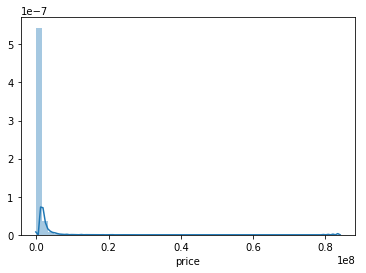

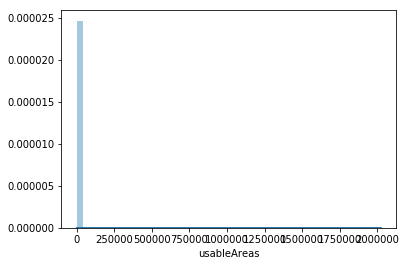

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [6]:
sns.distplot(df['price'])
plt.show()
sns.distplot(df['usableAreas'])
plt.show()

"""
As duas features do tipo contínua não estão normalizadas
"""

df['price'] = np.log(df['price'])
df['usableAreas'] = np.log(df['usableAreas'])

In [7]:
"""
A normalização de usableAreas produziu alguns valores infinitos
Eliminou-se eles
"""

df['usableAreas'] = np.log(df['usableAreas'])
df['usableAreas'] = df['usableAreas'].replace([np.inf, -np.inf], np.nan)
df = df.dropna()



c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [8]:
#No campo Zone há alguns nulos, preencheu-se estes campos com base nos bairros

preenche_zone = df.copy()
preenche_zone = preenche_zone[preenche_zone['zone']!=""]
preenche_zone = dict(zip(preenche_zone['bairro'], preenche_zone['zone']))
df['zone'] = df['bairro'].map(preenche_zone) 

### Verificação das features de Localização

Ao utilizar as features bairro, latitude, longitude, iria-se gerar muitas dummy variables, por isso foi averiguado se estas features tem relação com a variável preço

In [ ]:
geo = df[['lat', 'lon', 'price']]
geo = geo.sample(frac=0.8)
geo = geo.dropna()
geo = geo.reset_index(drop=True)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 15, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(geo[['lat', 'lon']])
y_kmeans2 = pd.get_dummies(y_kmeans)
y_kmeans = np.array(y_kmeans)
y_kmeans2.head()


regressor_OLS = sm.OLS(endog=geo['price'], exog=y_kmeans2).fit()

print(regressor_OLS.summary())

#utilizar latidade e longitude não parece ser uma boa ideia,
#o valor de R-square está muito baixo

## Análise Exploratória

In [ ]:
#PREÇO SEPARADOS POR ZONA
sns.distplot((df['price'][df['zone']=='Zona Sul']), label='Zona Sul')
sns.distplot((df['price'][df['zone']=='Zona Norte']), label='Zona Norte')
sns.distplot((df['price'][df['zone']=='Zona Leste']), label='Zona Leste')
sns.distplot((df['price'][df['zone']=='Centro']), label='Centro')
sns.distplot((df['price'][df['zone']=='Zona Oeste']), label='Zona Oeste')
plt.legend()

"""
Zona possui relação com preço
"""

In [ ]:
sns.distplot(df['price'][df['tipo']=='SALE'], label='SALE')
sns.distplot(df['price'][df['tipo']=='RENTAL'], label='RENTAL')
plt.legend()
plt.show()


sns.boxplot(df['price'], df['tipo'])
plt.show()

print(stats.skew(df['price']))
print(stats.kurtosis(df['price']))
"""
parece que o grande divisor de águas é o tipo de negócio (Venda ou aluguel)
"""

In [ ]:
df_test = df[(df['unitTypes']=='APARTMENT') | (df['unitTypes']=='TWO_STORY_HOUSE') |
             (df['unitTypes']=='HOME') | (df['unitTypes']=='CONDOMINIUM')]

sns.boxplot((df_test['price']),df_test['unitTypes'])

"""
Os dados entre os principais tipos de imóvel não diferem tanto,
excluiu-se eles
"""

In [ ]:
df_test = df[(df['logradouro']=='Rua') | (df['logradouro']=='Avenida')]

sns.distplot(((df_test['price'][df_test['logradouro']=='Rua'])), label='Rua')
sns.distplot(((df_test['price'][df_test['logradouro']=='Avenida'])), label='Avenida')
plt.legend()

print(stats.ttest_ind(df_test['price'][df_test['logradouro']=='Rua'],
               df_test['price'][df_test['logradouro']=='Avenida']))

"""
Não utilizou-se o logradouro, pois o valor-p está alto demais
iria-se somente acrescentar desinformação
"""

## Eliminando Outliers

In [9]:
#cópia de segurança
df3 = df.copy()

#Excluiu-se algumas features que apresentaram acrescentar pouca informação ao preço
df3 = df3.drop(['publicationType', 'totalAreas', 'unitTypes', 'logradouro'], axis=1)

A eliminação de outliers foram tratadas conforme as particularidades do tipo de venda (Venda ou Aluguel)

In [10]:
def outliers(df3, tipo):

    df3 = df3[df3['tipo']==tipo]

    # ---ELIMINANDO OUTLIERS GERAIS ---

    
    

    #eliminando outliers de price
    coluna = 'price'
    maximo = df3[coluna].quantile(.75) + (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    minimo = df3[coluna].quantile(.25) - (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    


    df3 = df3[(df3[coluna]<maximo) & (df3[coluna]>minimo)]
    
    
    
    #eliminando outliers de bathrooms
    coluna = 'bathrooms'
    maximo = df3[coluna].quantile(.75) + (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    minimo = df3[coluna].quantile(.25) - (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    


    df3 = df3[(df3[coluna]<maximo) & (df3[coluna]>minimo)]

    

    #eliminando outliers de bedrooms

    coluna = 'bedrooms'
    maximo = df3[coluna].quantile(.75) + (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    minimo = df3[coluna].quantile(.25) - (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    

    df3 = df3[(df3[coluna]<maximo) & (df3[coluna]>minimo)]

    #eliminando outliers de parkingSpaces

    coluna = 'parkingSpaces'
    maximo = df3[coluna].quantile(.75) + (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    minimo = df3[coluna].quantile(.25) - (df3[coluna].quantile(.75)-
                                         df3[coluna].quantile(.25))*1.5
    

    
    df3 = df3[(df3[coluna]<maximo) & (df3[coluna]>minimo)]

    

    df3 = df3.reset_index(drop=True)

    # --- ELIMINANDO OUTLIERS POR CATEGORIA ---

    #eliminando outliers de bathrooms
    coluna = 'bathrooms'

    vetor = []

    for i in range(int(df3[coluna].min()),int((df3[coluna].max()+1))):
        bd = df3[df3[coluna]==i]

        maximo = bd['price'].quantile(.75) + (bd['price'].quantile(.75)-
                                             bd['price'].quantile(.25))*1.5
        minimo = bd['price'].quantile(.25) - (bd['price'].quantile(.75)-
                                             bd['price'].quantile(.25))*1.5
        vetor.append([maximo, minimo])

    df3[coluna] = df3[coluna].astype('int')

    a_deletar = []
    for i in range(len(df3)):
        qnt_ban = df3[coluna][i]
        if((df3['price'][i]>vetor[qnt_ban][0]) | (df3['price'][i]<vetor[qnt_ban][1])):
            a_deletar.append(i)

    df3 = df3.drop(a_deletar, axis=0)
    df3 = df3.reset_index(drop=True) 

    #eliminando outliers de bedrooms
    coluna = 'bedrooms'

    vetor = []

    for i in range(int(df3[coluna].min()),int((df3[coluna].max()+1))):
        bd = df3[df3[coluna]==i]

        maximo = bd['price'].quantile(.75) + (bd['price'].quantile(.75)-
                                             bd['price'].quantile(.25))*1.5
        minimo = bd['price'].quantile(.25) - (bd['price'].quantile(.75)-
                                             bd['price'].quantile(.25))*1.5
        vetor.append([maximo, minimo])

    df3[coluna] = df3[coluna].astype('int')

    

    a_deletar = []
    for i in range(len(df3)):
        qnt_ban = df3[coluna][i]-1
        if((df3['price'][i]>vetor[qnt_ban][0]) | (df3['price'][i]<vetor[qnt_ban][1])):
            a_deletar.append(i)

    df3 = df3.drop(a_deletar, axis=0)
    df3 = df3.reset_index(drop=True) 

    #eliminando outliers de parkingSpaces
    coluna = 'parkingSpaces'

    vetor = []

    for i in range(int(df3[coluna].min()),int((df3[coluna].max()+1))):
        bd = df3[df3[coluna]==i]

        maximo = bd['price'].quantile(.75) + (bd['price'].quantile(.75)-
                                             bd['price'].quantile(.25))*1.5
        minimo = bd['price'].quantile(.25) - (bd['price'].quantile(.75)-
                                             bd['price'].quantile(.25))*1.5
        vetor.append([maximo, minimo])

    df3[coluna] = df3[coluna].astype('int')
    

    a_deletar = []
    for i in range(len(df3)):
        qnt_ban = df3[coluna][i]
        if((df3['price'][i]>vetor[qnt_ban][0]) | (df3['price'][i]<vetor[qnt_ban][1])):
            a_deletar.append(i)

    df3 = df3.drop(a_deletar, axis=0)
    df3 = df3.reset_index(drop=True) 
    
    return df3

In [11]:
junta = outliers(df3, 'SALE')
junta = junta.append(outliers(df3, 'RENTAL'))

In [12]:
#Tratamento da feature Zone
zonas = pd.get_dummies(junta['zone'], drop_first=True)
junta = junta.drop('zone', axis=1)
junta['Zona Leste'] = zonas['Zona Leste']
junta['Zona Norte'] = zonas['Zona Norte']
junta['Zona Oeste'] = zonas['Zona Oeste']
junta['Zona Sul'] = zonas['Zona Sul']

In [13]:
lb_tipo = LabelEncoder()
junta['tipo'] = lb_tipo.fit_transform(junta['tipo'])


Statsmodels

In [ ]:
#não vamos utilizar bairro, porque iria criar muitas dummy variables
X = junta[['bathrooms', 'bedrooms', 'parkingSpaces', 'usableAreas', 'tipo', 'Zona Norte', 'Zona Oeste', 'Zona Leste', 'Zona Sul']]
y = junta[['price']]

regressor_OLS = sm.OLS(endog=y, exog=X).fit()

print(regressor_OLS.summary())


In [14]:
X = junta[['bathrooms', 'bedrooms', 'usableAreas', 'tipo', 'Zona Norte', 'Zona Oeste', 'Zona Sul', 'Zona Leste']]
y = junta[['price']]

regressor_OLS = sm.OLS(endog=y, exog=X).fit()

print(regressor_OLS.summary())

"""
Eliminou-se parkingSpaces por estar acrescentando desinformação
E 
"""

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.426e+06
Date:                Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:40:59   Log-Likelihood:                -50714.
No. Observations:               65840   AIC:                         1.014e+05
Df Residuals:                   65832   BIC:                         1.015e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bathrooms       0.0228      0.002     13.230      

'\nEliminou-se parkingSpaces por estar acrescentando desinformação\nE \n'

## Modelos

In [15]:
mm_usableAreas = MinMaxScaler(feature_range=(0, 1))
mm_price = MinMaxScaler(feature_range=(0, 1))


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 0)

y_train = mm_price.fit_transform(y_train)
y_test = mm_price.transform(y_test)


X_train['usableAreas'] = mm_usableAreas.fit_transform(X_train[['usableAreas']])

X_test['usableAreas'] = mm_usableAreas.transform(X_test[['usableAreas']])

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
X_train = X_train.values
X_test = X_test.values

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
classifier = GradientBoostingRegressor()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
y_test2 = np.exp(mm_price.inverse_transform(y_test))
y_pred2 = np.exp(mm_price.inverse_transform(y_pred.reshape(-1,1)))

In [19]:
mape = (np.mean(np.abs(((y_test2) - (y_pred2)) / (y_test2))) * 100)
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))

print('MAPE = {}, RMSE = {}'.format(mape, rmse))



MAPE = 31.688862397173985, RMSE = 264172.6713128313


In [20]:
classifier.feature_importances_

array([9.53048658e-03, 3.59708460e-03, 6.09619830e-02, 9.23230620e-01,
       2.55254629e-03, 3.76027443e-05, 7.74540639e-05, 1.22231772e-05])

## Aprimoramento

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, check_cv
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
predict = cross_val_predict(estimator=classifier, X=X_train, y= y_train, cv = 5)

In [ ]:
accuracies.mean()

Validação Cruzada

In [21]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators': [600, 900], 'learning_rate': [0.1],
              'loss': ['ls']}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 10,
                           )

In [22]:
grid_search = grid_search.fit(X_train, y_train)

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensem

In [23]:
print(grid_search.best_params_)
print(grid_search.estimator.feature_importances_)

{'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 900}
[9.53048658e-03 3.59708460e-03 6.09619830e-02 9.23230620e-01
 2.55254629e-03 3.76027443e-05 7.74540639e-05 1.22231772e-05]


In [24]:
y_pred = grid_search.predict(X_test)

In [25]:
y_test2 = np.exp(mm_price.inverse_transform(y_test))
y_pred2 = np.exp(mm_price.inverse_transform(y_pred.reshape(-1,1)))

In [26]:
mape = (np.mean(np.abs(((y_test2) - (y_pred2)) / (y_test2))) * 100)
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))

print('MAPE = {}, RMSE = {}'.format(mape, rmse))

MAPE = 30.852569991020374, RMSE = 257355.6044938985


Melhor Faixa de preço

Text(0, 0.5, 'pred')

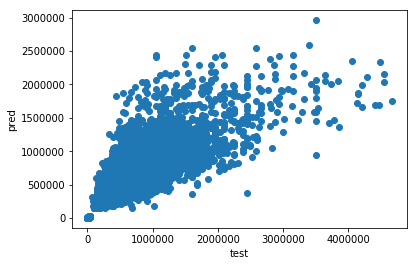

In [27]:
plt.scatter(y_test2, y_pred2)
plt.xlabel('test')
plt.ylabel('pred')

In [28]:
y_test3 = []
y_pred3 = []
for i in range(len(y_test2)):
    y_test3.append(y_test2[i][0])
    y_pred3.append(y_pred2[i][0])
    
y_test3 = np.array(y_test3)
y_pred3 = np.array(y_pred3)

In [29]:
erros = pd.DataFrame(y_test3, y_pred3)
erros = erros.reset_index()
erros.columns = ['test', 'pred']

erros = erros.round()

In [30]:
erros = erros.sort_values('test')
erros = erros.reset_index(drop=True)

In [31]:
erros['erro'] =  erros['test'] - erros['pred']

In [32]:
cat_erro = []
for i in range(0, 13000, 100):
    cat_erro.append(erros['erro'][i:i+100].mean())

In [33]:
np.array(np.abs(cat_erro)).argsort()

array([  5,  10,   0,   1,   9,   7,   8,   3,   2,  11,   4,   6,  13,
        12,  16,  15,  17,  14,  44,  27,  20,  19,  88,  21,  26,  24,
        18,  22,  25,  23,  99,  28,  50,  56,  51,  35,  36,  34,  29,
        48,  94,  49,  98,  57,  42,  32,  31,  87,  45,  54,  40,  38,
        33, 103,  37,  66,  30, 100,  39,  93,  59,  53, 105,  74,  46,
        41,  43,  73,  70,  81,  60,  65,  86,  63,  84,  52,  69,  90,
        47,  67,  64,  55,  62,  80,  71,  72,  82,  92,  75,  68,  78,
        58,  76,  96,  77,  61,  79, 107, 101, 114,  83,  95,  85, 102,
       109,  89,  97,  91, 117, 108, 115, 112, 104, 110, 111, 106, 113,
       118, 116, 128, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129],
      dtype=int64)

In [38]:
print(cat_erro[5])
print(erros['erro'][500:600].mean())

-82.34
-82.34


A melhor faixa de preço deste modelo é de 500 - 600 reais

## Submetendo Dados de Avaliação

In [39]:
test = []
with open('F:/Bruno 02/Datasets/GrupoZap/source-4-ds-test.json', encoding="utf8") as f:
    for line in f:
        test.append(json.loads(line))

In [40]:
test = pd.DataFrame(test)

In [41]:
#função



bairro = []
for i in range(len(test)):
    try:
        bairro.append(str.split(data[i]['address']['locationId'], ">")[-1])
    except:
        bairro.append(np.nan)

tipo = []
for i in range(len(test)):
    try:
        tipo.append(test['pricingInfos'][i]['businessType'])
    except:
        tipo.append(np.nan)



zone = []
for i in range(len(test)):
    try:
        zone.append(test['address'][i]['zone'])
    except:
        zone.append(np.nan)
        

test['zone'] = zone
test['tipo'] = tipo
test['bairro'] = bairro


test = test.drop(['address', 'createdAt', 'description', 'id', 'images', 'listingStatus',
               'pricingInfos', 'publisherId', 'title', 'updatedAt'], axis=1)


In [42]:
test['usableAreas'] = np.log(test['usableAreas'])

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [43]:
preenche_zone = test.copy()
preenche_zone = preenche_zone[preenche_zone['zone']!=""]
preenche_zone = dict(zip(preenche_zone['bairro'], preenche_zone['zone']))
test['zone'] = test['bairro'].map(preenche_zone) 

In [44]:
test = test.drop(['publicationType', 'totalAreas', 'unitTypes', 'owner', 'suites', 'bairro'], axis=1)

In [45]:
test['tipo'] = lb_tipo.transform(test['tipo'])

In [46]:
zonas2 = pd.get_dummies(test['zone'], drop_first=True)
test = test.drop('zone', axis=1)
test['Zona Leste'] = zonas2['Zona Leste']
test['Zona Norte'] = zonas2['Zona Norte']
test['Zona Oeste'] = zonas2['Zona Oeste']
test['Zona Sul'] = zonas2['Zona Sul']

In [58]:
X2 = test[['bathrooms', 'bedrooms', 'usableAreas', 'tipo', 'Zona Norte', 'Zona Oeste', 'Zona Sul', 'Zona Leste']]

In [59]:
X2['usableAreas'] = X2['usableAreas'].replace([np.inf, -np.inf], 0)

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
X2['usableAreas'] = mm_usableAreas.transform(X2[['usableAreas']])

c:\users\bruno\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16036 entries, 0 to 16035
Data columns (total 8 columns):
bathrooms      16036 non-null float64
bedrooms       16036 non-null int64
usableAreas    16036 non-null float64
tipo           16036 non-null int32
Zona Norte     16036 non-null uint8
Zona Oeste     16036 non-null uint8
Zona Sul       16036 non-null uint8
Zona Leste     16036 non-null uint8
dtypes: float64(2), int32(1), int64(1), uint8(4)
memory usage: 501.2 KB


In [68]:
X2 = X2.fillna(method='backfill')

In [72]:
y_pred2 = grid_search.predict(X2)

array([[ 188694.71711998],
       [ 480489.52589417],
       [ 606991.46981249],
       ...,
       [ 540614.07495464],
       [ 391508.44841183],
       [1173149.11469723]])

In [76]:
y_pred2 = np.exp(mm_price.inverse_transform(y_pred2.reshape(-1,1)))

In [ ]:
pd.DataFrame(y_pred2).to_csv('exporta.csv')